## VQGAN

### Download checkpoints

- Download pre-trained VQGAN checkpoint from https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/
- Download pre-trained LPIPS checkpoint from https://heibox.uni-heidelberg.de/f/607503859c864bc1b30b/?dl=1

### Load model

In [1]:
import sys
sys.path.append('../src')

In [4]:
import torch

from torchvision import transforms
from torch.utils.data import DataLoader

from vqgan.model import VQModel
from data import VQVisualNewsDataset

In [5]:
ddconfig = {
    'double_z': False,
    'z_channels': 256,
    'resolution': 256,
    'in_channels': 3,
    'out_ch': 3,
    'ch': 128,
    'ch_mult': [1, 1, 2, 2, 4],
    'num_res_blocks': 2,
    'attn_resolutions': [16],
    'dropout': 0.0
}

lossconfig = {
    'disc_conditional': False,
    'disc_in_channels': 3,
    'disc_start': 0,
    'disc_weight': 0.75,
    'disc_num_layers': 2,
    'codebook_weight': 1.0,
    'lpips_ckpt_path': '../src/checkpoints/lpips/vgg.pth'
}

config = {'ddconfig': ddconfig, 'lossconfig': lossconfig, 'n_embed': 16384, 'embed_dim': 256}

In [6]:
# ckpt = torch.load('../src/checkpoints/vqgan/last.ckpt', map_location='cpu')
# ckpt.keys()
# # dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'callbacks', 'optimizer_states', 'lr_schedulers', 'state_dict'])

In [9]:
model = VQModel.from_checkpoint('../src/checkpoints/vqgan/last.ckpt', config)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/jupyter/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VQLPIPSWithDiscriminator running with hinge loss.


In [15]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [16]:
train_set = VQVisualNewsDataset('../src/data/visual_news_mini', transform)

In [17]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)

In [18]:
import io

import torchvision
import numpy as np
import matplotlib.pyplot as plt
import requests

from PIL import Image


def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content))


def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

    
def show_random_batch(data_loader):
    # Get a random batch
    images = next(iter(data_loader))

    imshow(torchvision.utils.make_grid(images))
    plt.show()


def visualize_model_batch(batch):
    # Encoded image tokens
    quant_states, loss, info = model.encode(batch)
    
    # Decode image tokens, i.e. reconstruct image from image tokens
    rec = model.decode(quant_states)
    
    # Display
    imshow(torchvision.utils.make_grid(batch), 'Original')
    plt.show()
    imshow(torchvision.utils.make_grid(rec.detach()), 'Reconstructed')
    plt.show()


def visualize_model(data_loader):
    # Get a random batch
    images = next(iter(data_loader))
    
    visualize_model_batch(images)

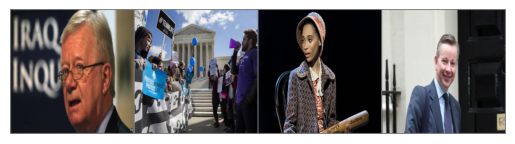

In [19]:
show_random_batch(train_loader)

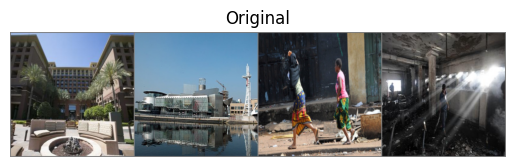

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


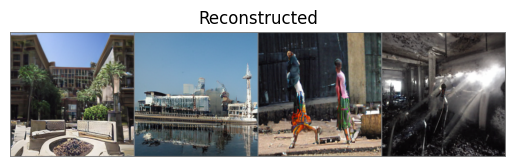

In [20]:
visualize_model(train_loader)

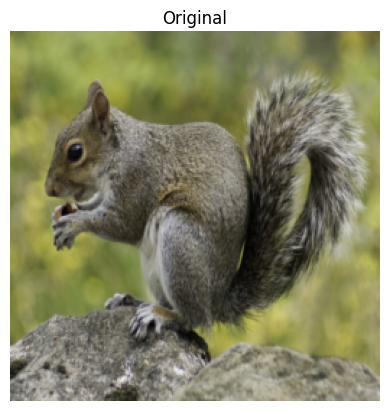

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


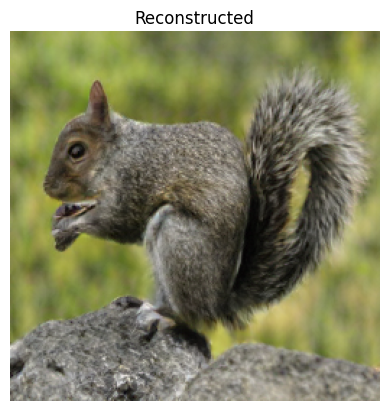

In [21]:
# Download an image, encode it, and then reconstruct

# Load the image
sample_img = download_image('https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1')

# Preprocess the image using the transformation pipeline
sample_tensor = transform(sample_img)

# Add a batch dimension to the tensor
sample_batch = sample_tensor.unsqueeze(0)

visualize_model_batch(sample_batch)

## Train

In [25]:
# Set up the optimizer for the autoencoder and discriminator
base_lr = 4.5e-06
opt_ae, opt_disc = model.configure_optimizers(learning_rate=base_lr)

opt_states = torch.load('../src/checkpoints/vqgan/last.ckpt', map_location='cpu')['optimizer_states']
opt_ae.load_state_dict(opt_states[0])
opt_disc.load_state_dict(opt_states[1])

In [26]:
# Training loop

for epoch in range(1):
    print('\nEpoch:', epoch + 1)
    for i, inputs in enumerate(train_loader):
        # Update the autoencoder
        aeloss, log_dict_ae = model.training_step(inputs, 0)
        
        # Update the discriminator
        discloss, log_dict_disc = model.training_step(inputs, 1)
        
        # Update global step
        model.step()
        
        # Print statistics every 2 mini-batches
        if i % 2 == 0:
            print('  step:', i, 'ae_loss:', aeloss.item(), 'disc_loss:', discloss.item())
        
        # For now, let's train for 10 mini-batches
        if i >= 10:
            break


Epoch: 1
  step: 0 ae_loss: -771.5474853515625 disc_loss: 1.0000004768371582
  step: 2 ae_loss: -562.1310424804688 disc_loss: 0.9999985694885254
  step: 4 ae_loss: -1663.295166015625 disc_loss: 1.0000005960464478
  step: 6 ae_loss: -767.9966430664062 disc_loss: 1.000001311302185
  step: 8 ae_loss: -426.06536865234375 disc_loss: 1.000000238418579
  step: 10 ae_loss: -1211.824951171875 disc_loss: 1.0000001192092896


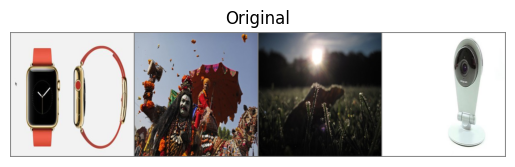

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


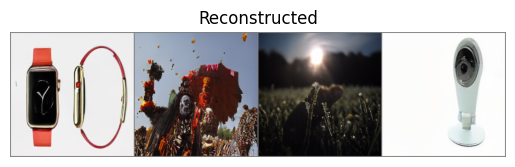

In [27]:
visualize_model(train_loader)

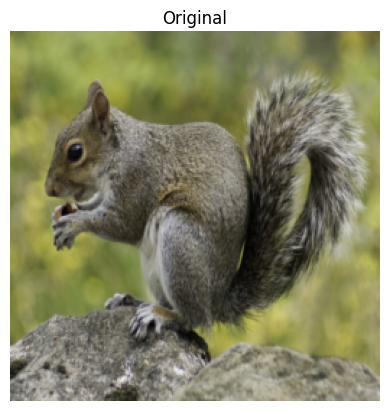

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


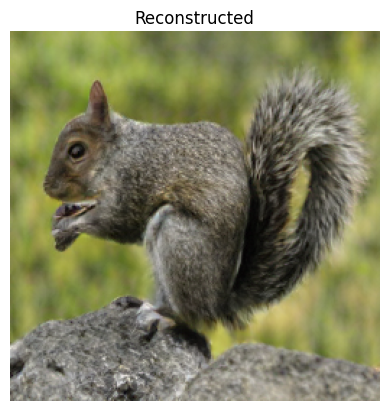

In [24]:
visualize_model_batch(sample_batch)

In [33]:
#save model
PATH = "../src/checkpoints/vqgan/finetuned.ckpt"

torch.save({
    'epoch': 1,
    'optimizer_states': [opt_ae.state_dict(), opt_disc.state_dict()],
    'lr_schedulers': base_lr,
    'state_dict': model.state_dict()
}, PATH)

In [38]:
#load model
checkpoint = torch.load(PATH, map_location='cpu')
model.load_state_dict(checkpoint['state_dict'])
opt_states = checkpoint['optimizer_states']
opt_ae.load_state_dict(opt_states[0])
opt_disc.load_state_dict(opt_states[1])
epoch = checkpoint['epoch']

In [ ]:
visualize_model(train_loader)